### Printing out the Branches in the data.

In [38]:
##### import ROOT
f = ROOT.TFile.Open("/mnt/data/eos/run307/run307.root")
events = f.Get("events")
events.Print()

******************************************************************************
*Tree    :events    : events                                                 *
*Entries :     8436 : Total =       126980201 bytes  File  Size =   37367136 *
*        :          : Tree compression factor =   3.40                       *
******************************************************************************
*Br    0 :event_number : event_number/I                                      *
*Entries :     8436 : Total  Size=      34419 bytes  File Size  =      12007 *
*Baskets :        2 : Basket Size=      51200 bytes  Compression=   2.82     *
*............................................................................*
*Br    1 :nhit      : nhit/I                                                 *
*Entries :     8436 : Total  Size=      34371 bytes  File Size  =      12831 *
*Baskets :        2 : Basket Size=      51200 bytes  Compression=   2.64     *
*...................................................

### PMT Hits Map ###
The code block will open the root data file and grab the branches (some of these are vectors).<br>
Then loop through each of the event and hit and make a histogram out of the number of hits for each PMT.<br>
Then the map of Board# vs Channel are made.<br>
Board 14 Channel 12 to Board 15 Channel 14 are those will Muon paddle outputs.<br>

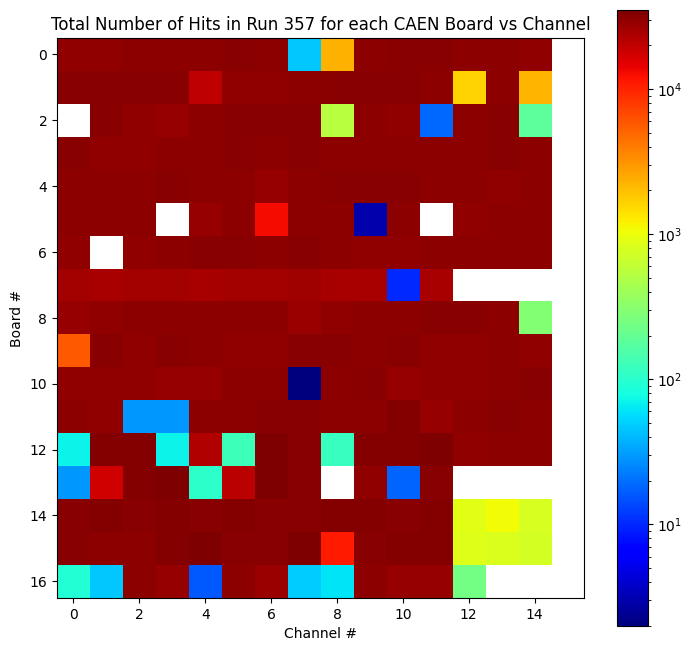

nMuonHits nTotalHits nMuonHits/nTotalHits
70675.0 6367306.0 0.011099670724164977
nhits in B14C11-B15-C14
[[32860.   869.  1058.   792.]
 [32699.   835.   811.   751.]]


In [8]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd

run_number = "357"

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
charge = rdf.AsNumpy(columns=["charge"])["charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

#print(len(charge[0]))
#print(nhit[0])

PMTHits = np.zeros([17,16])
#print(PMTHits.shape)
for iEvt in range(0,len(event_number)):
    #print(len(board[aEvt]),len(channel[aEvt]), nhit[aEvt])
    for iHit in range(0,len(board[iEvt])):
        #print(board[iEvt][iHit])
        PMTHits[board[iEvt][iHit],channel[iEvt][iHit]]=PMTHits[board[iEvt][iHit],channel[iEvt][iHit]]+1

plt.figure(figsize=(17/2,16/2))
plt.imshow(PMTHits, cmap='jet',norm=colors.LogNorm())
plt.title("Total Number of Hits in Run "+run_number+" for each CAEN Board vs Channel")
plt.xlabel("Channel #")
plt.ylabel("Board #")
plt.colorbar()
plt.show()

nMuonHits = np.sum(PMTHits[14:16,11:15])
nTotalHits= np.sum(PMTHits)
print("nMuonHits nTotalHits nMuonHits/nTotalHits")
print(nMuonHits,nTotalHits,nMuonHits/nTotalHits)
print("nhits in B14C11-B15-C14")
print(PMTHits[14:16,11:15])


### Now, let's see if we can get coincidences of the paddles.
The code opens the file, grab the branches<br>
Then it loops through each event.<br>
    Create a 2x3 array (for the 6 powered up muon paddles) for each event.<br>
    Then fill the array with whether or not a hit occurred in the paddles.<br>
    Then it looks in the array to see if there are coincidences between top, middle, bottom paddles<br>

Total Events= 58988  Zeros=  54646  Singles=  1562  Doubles=  617  Triples= 13


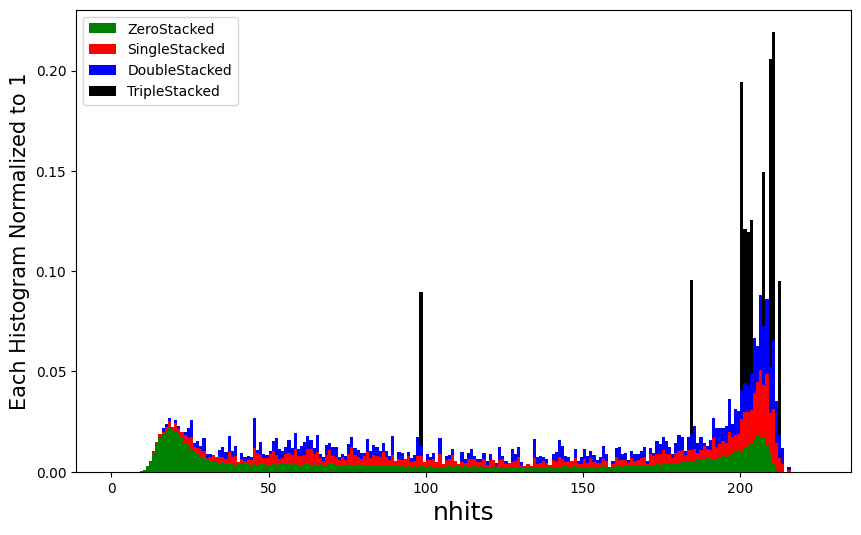

In [37]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

run_number = "357"

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
charge = rdf.AsNumpy(columns=["charge"])["charge"]

nZero=0
nSingle=0
nDouble=0
nTriple=0

nhitZero = []
nhitSingle = []
nhitDouble = []
nhitTriple = []


for iEvt in range(0,len(event_number)):
    MuonHits = np.zeros([2,3])    
    for iHit in range(0,len(board[iEvt])):
        if  (board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 12):
           MuonHits[0,0]=1
        elif(board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 13):
           MuonHits[0,1]=1      
        elif(board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 14):
           MuonHits[0,2]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 12):
           MuonHits[1,0]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 13):
           MuonHits[1,1]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 14):
           MuonHits[1,2]=1

    if(np.sum(MuonHits)==0): 
        nZero+=1
        nhitZero.append(nhit[iEvt])

    if(MuonHits[1,0] or MuonHits[1,2]):
        nSingle+=1
        nhitSingle.append(nhit[iEvt])
        if(MuonHits[1,1] or MuonHits[0,2]):
            #print("Double!",iEvt)
            nDouble+=1
            nhitDouble.append(nhit[iEvt])
            if(MuonHits[0,0] or MuonHits[0,1]):
                #print("Triple!",iEvt)
                nTriple+=1
                nhitTriple.append(nhit[iEvt])

print("Total Events=",len(event_number)," Zeros= ",nZero," Singles= ",nSingle," Doubles= ",nDouble, " Triples=",nTriple)
plt.figure(figsize=(10,6))

weightsZero = np.ones_like(nhitZero) / len(nhitZero)
weightsSingle = np.ones_like(nhitSingle) / len(nhitSingle)
weightsDouble = np.ones_like(nhitDouble) / len(nhitDouble)
weightsTriple = np.ones_like(nhitTriple) / len(nhitTriple)

plt.hist([nhitZero,nhitSingle,nhitDouble,nhitTriple],weights=[weightsZero,weightsSingle,weightsDouble,weightsTriple],label=["ZeroStacked","SingleStacked","DoubleStacked","TripleStacked"],
         color=["green","red","blue","black"],bins=range(0,225), stacked=True)
#plt.hist(nhitZero,color="green",alpha=0.7,label="ZeroNOTStacked",bins=range(0,225),density=True)

plt.xlabel("nhits",fontsize=18)
plt.ylabel("Each Histogram Normalized to 1",fontsize=15)
plt.legend()
#plt.yscale('log')
plt.show()

Total Events= 58988  Zeros=  54645  Singles=  1562  Doubles=  617  Triples= 13


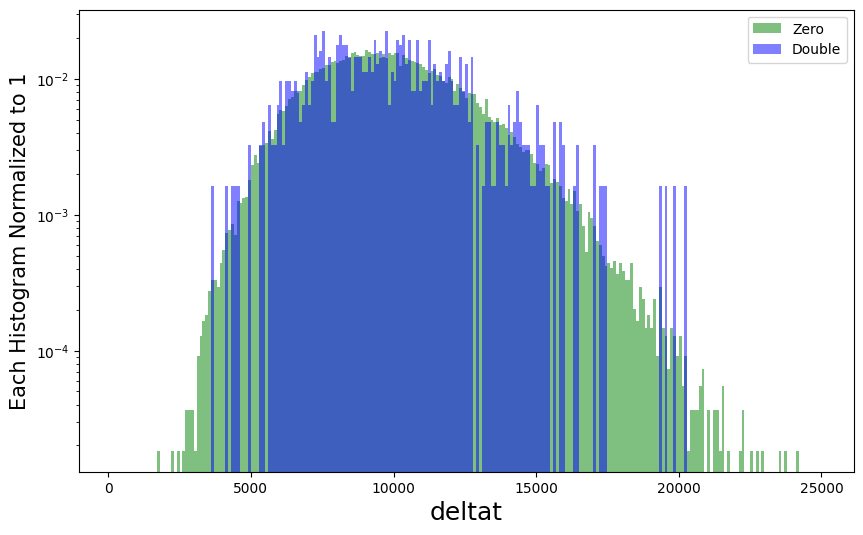

In [42]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

run_number = "357"

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
charge = rdf.AsNumpy(columns=["charge"])["charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

nZero=0
nSingle=0
nDouble=0
nTriple=0

deltatZero = []
deltatSingle = []
deltatDouble = []
deltatTriple = []


for iEvt in range(0,len(event_number)-1):
    MuonHits = np.zeros([2,3])    
    for iHit in range(0,len(board[iEvt])):
        if  (board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 12):
           MuonHits[0,0]=1
        elif(board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 13):
           MuonHits[0,1]=1      
        elif(board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 14):
           MuonHits[0,2]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 12):
           MuonHits[1,0]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 13):
           MuonHits[1,1]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 14):
           MuonHits[1,2]=1

    if(np.sum(MuonHits)==0): 
        nZero+=1
        deltatZero.append(deltat[iEvt+1])

    if(MuonHits[1,0] or MuonHits[1,2]):
        nSingle+=1
        deltatSingle.append(deltat[iEvt+1])
        if(MuonHits[1,1] or MuonHits[0,2]):
            #print("Double!",iEvt)
            nDouble+=1
            deltatDouble.append(deltat[iEvt+1])
            if(MuonHits[0,0] or MuonHits[0,1]):
                #print("Triple!",iEvt)
                nTriple+=1
                deltatTriple.append(deltat[iEvt+1])

print("Total Events=",len(event_number)," Zeros= ",nZero," Singles= ",nSingle," Doubles= ",nDouble, " Triples=",nTriple)
plt.figure(figsize=(10,6))

weightsZero = np.ones_like(deltatZero) / len(deltatZero)
weightsSingle = np.ones_like(deltatSingle) / len(deltatSingle)
weightsDouble = np.ones_like(deltatDouble) / len(deltatDouble)
weightsTriple = np.ones_like(deltatTriple) / len(deltatTriple)

plt.hist(deltatZero,weights=weightsZero,label="Zero",color="green",bins=range(200,24000,200),alpha=0.5)
plt.hist(deltatDouble,weights=weightsDouble,label="Double",color="blue",bins=range(200,24000,200),alpha=0.5)
         
#plt.hist(nhitZero,color="green",alpha=0.7,label="ZeroNOTStacked",bins=range(0,225),density=True)

plt.xlabel("deltat",fontsize=18)
plt.ylabel("Each Histogram Normalized to 1",fontsize=15)
plt.legend()
plt.yscale('log')
plt.show()